In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 8)
import seaborn as sns

import optuna
import sklearn
import lightgbm

In [3]:
train = pd.read_csv('/Users/abilfad/Downloads/weather-forecasting-datavidia/data/train.csv')
train['time'] = pd.to_datetime(train['time'])
train_hourly = pd.read_csv('/Users/abilfad/Downloads/weather-forecasting-datavidia/data/train_hourly.csv')
train_hourly['time'] = pd.to_datetime(train_hourly['time'])

train = train.set_index('time')
train_hourly = train_hourly.set_index('time')

In [4]:
print(train.info(), train_hourly.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13258 entries, 2018-01-01 to 2022-12-28
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   temperature_2m_max (°C)          13208 non-null  float64
 1   temperature_2m_min (°C)          13208 non-null  float64
 2   apparent_temperature_max (°C)    13208 non-null  float64
 3   apparent_temperature_min (°C)    13208 non-null  float64
 4   sunrise (iso8601)                13258 non-null  object 
 5   sunset (iso8601)                 13258 non-null  object 
 6   shortwave_radiation_sum (MJ/m²)  13198 non-null  float64
 7   rain_sum (mm)                    13198 non-null  float64
 8   snowfall_sum (cm)                13198 non-null  float64
 9   windspeed_10m_max (km/h)         13208 non-null  float64
 10  windgusts_10m_max (km/h)         13208 non-null  float64
 11  winddirection_10m_dominant (°)   12792 non-null  float64
 12  e

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m_max (°C),13208.0,23.145215,12.856324,-30.0,18.60,28.90,31.30,38.90
temperature_2m_min (°C),13208.0,17.402991,12.248475,-33.4,11.60,24.20,25.40,28.50
apparent_temperature_max (°C),13208.0,26.699992,16.617231,-34.8,20.30,34.60,37.80,46.20
apparent_temperature_min (°C),13208.0,19.709888,15.796247,-38.2,11.40,28.60,30.60,34.50
shortwave_radiation_sum (MJ/m²),13198.0,17.043767,6.460664,0.0,13.61,18.43,21.52,32.42
rain_sum (mm),13198.0,6.330224,9.457546,0.0,0.00,2.20,9.30,182.70
snowfall_sum (cm),13198.0,0.086511,0.541745,0.0,0.00,0.00,0.00,24.36
windspeed_10m_max (km/h),13208.0,11.566308,6.125631,2.6,7.20,10.20,14.40,62.30
windgusts_10m_max (km/h),13208.0,28.175780,9.003485,6.8,22.30,26.60,32.40,129.20
winddirection_10m_dominant (°),12792.0,166.380863,93.806254,0.0,96.00,157.00,241.00,360.00


In [6]:
train_hourly.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m (°C),318022.0,19.233679,12.766816,-34.800,14.700,25.000,27.200,36.900
relativehumidity_2m (%),318022.0,82.932319,13.451436,21.000,76.000,87.000,93.000,100.000
dewpoint_2m (°C),318022.0,16.120571,13.362998,-45.200,13.000,22.700,24.300,29.600
apparent_temperature (°C),318022.0,22.651936,16.119087,-38.200,16.100,30.300,33.200,46.200
pressure_msl (hPa),318022.0,1011.750079,4.898858,963.600,1009.400,1011.300,1013.800,1057.000
surface_pressure (hPa),318022.0,960.336812,81.407759,737.500,973.000,990.700,1010.000,1032.200
snowfall (cm),318022.0,0.003651,0.030587,0.000,0.000,0.000,0.000,2.100
cloudcover (%),318022.0,57.211454,31.152322,0.000,33.000,56.000,87.000,100.000
cloudcover_low (%),318022.0,28.164819,29.250489,0.000,5.000,17.000,42.000,100.000
cloudcover_mid (%),318022.0,31.059854,31.698668,0.000,5.000,20.000,49.000,100.000


In [7]:
train.isna().sum()

temperature_2m_max (°C)             50
temperature_2m_min (°C)             50
apparent_temperature_max (°C)       50
apparent_temperature_min (°C)       50
sunrise (iso8601)                    0
sunset (iso8601)                     0
shortwave_radiation_sum (MJ/m²)     60
rain_sum (mm)                       60
snowfall_sum (cm)                   60
windspeed_10m_max (km/h)            50
windgusts_10m_max (km/h)            50
winddirection_10m_dominant (°)     466
et0_fao_evapotranspiration (mm)     60
elevation                            0
city                                 0
dtype: int64

In [8]:
train_hourly.isna().sum()

temperature_2m (°C)                   170
relativehumidity_2m (%)               170
dewpoint_2m (°C)                      170
apparent_temperature (°C)             170
pressure_msl (hPa)                    170
surface_pressure (hPa)                170
snowfall (cm)                         170
cloudcover (%)                        170
cloudcover_low (%)                    170
cloudcover_mid (%)                    170
cloudcover_high (%)                   170
shortwave_radiation (W/m²)            170
direct_radiation (W/m²)               170
diffuse_radiation (W/m²)              170
direct_normal_irradiance (W/m²)       160
windspeed_10m (km/h)                  170
windspeed_100m (km/h)                 170
winddirection_10m (°)                 602
winddirection_100m (°)                347
windgusts_10m (km/h)                  170
et0_fao_evapotranspiration (mm)       170
vapor_pressure_deficit (kPa)          170
soil_temperature_0_to_7cm (°C)        170
soil_temperature_7_to_28cm (°C)   

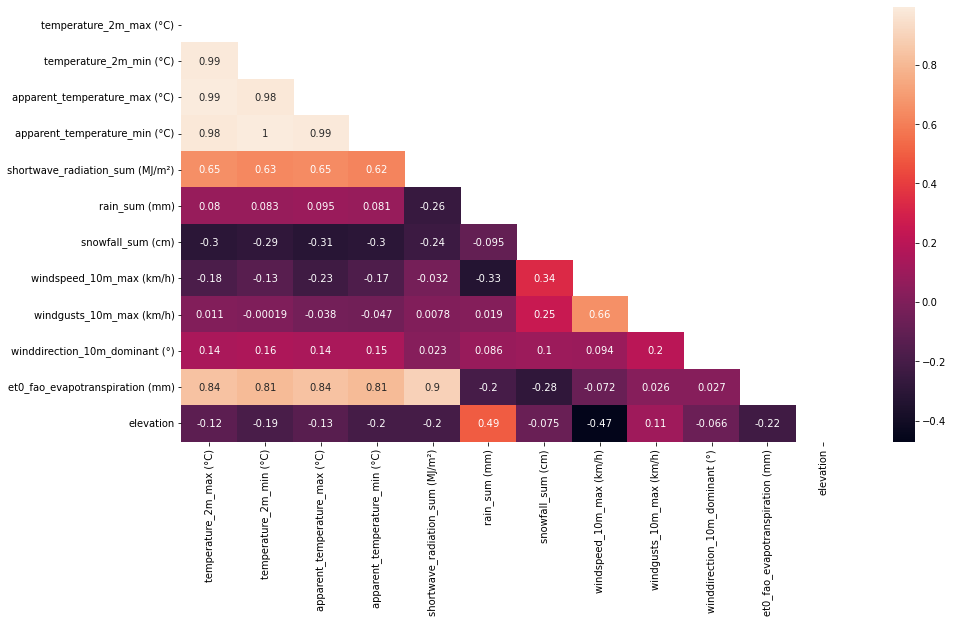

In [9]:
### Checking Correlation : 
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(train.corr(),annot=True,mask=mask)

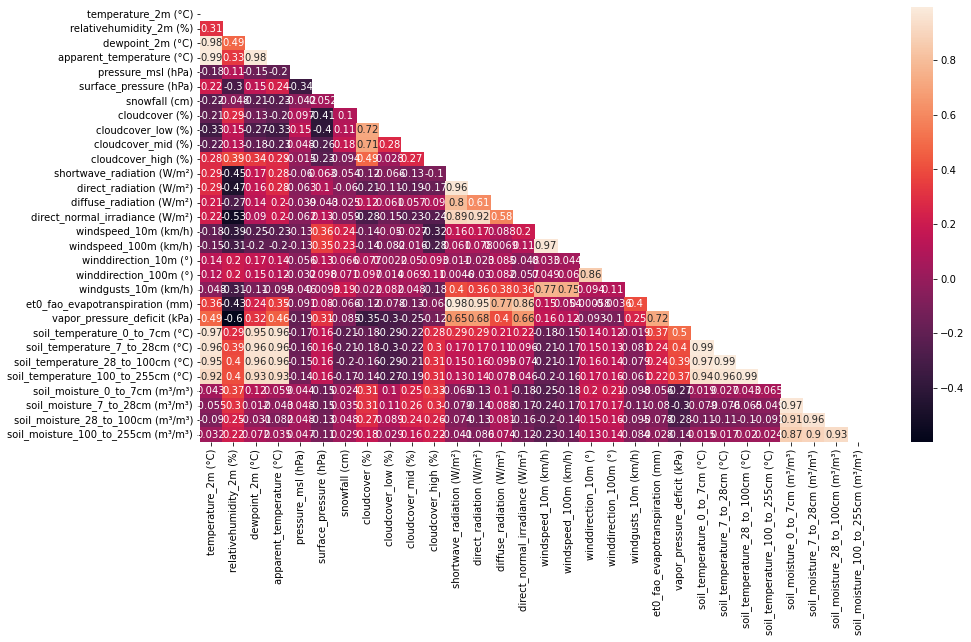

In [10]:
mask = np.triu(np.ones_like(train_hourly.corr()))
sns.heatmap(train_hourly.corr(),annot=True,mask=mask)

In [190]:
### City and Elevation relationship : 
city = train.city.unique()
for c in city :
    print(c,train[train['city']==c]['elevation'].unique())

su [0]
si [0]
u [0]
le [0]
p [58]
lh [5]
b [1391]
t [2678]
sa [17]
q [0]


## EDA

In [11]:
city = train.city.unique()
train.city.unique(), train_hourly.city.unique()

(array(['su', 'si', 'u', 'le', 'p', 'lh', 'b', 't', 'sa', 'q'],
       dtype=object),
 array(['su', 'si', 'u', 'le', 'p', 'lh', 'b', 't', 'sa', 'q'],
       dtype=object))

In [12]:
train.columns

Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)',
       'sunrise (iso8601)', 'sunset (iso8601)',
       'shortwave_radiation_sum (MJ/m²)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'windspeed_10m_max (km/h)', 'windgusts_10m_max (km/h)',
       'winddirection_10m_dominant (°)', 'et0_fao_evapotranspiration (mm)',
       'elevation', 'city'],
      dtype='object')

In [13]:
def seperate_city(data):
    city = data.city.unique()
    city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10 = np.zeros(10)
    city_arr = [city_1,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10]
    for i in range(len(city)) :
        city_arr[i] = data[data['city']==city[i]]
        city_arr[i].to_csv(f'../data/per_city/file_{city[i]}.csv')


### B city 

In [164]:
train_b = pd.read_csv('../data/per_city/train_b.csv')
train_b['time'] = pd.to_datetime(train_b['time'])
train_b = train_b.set_index('time')

train_hourly_b = pd.read_csv('../data/train_per_city/train_hourly_b.csv')
train_hourly_b['time'] = pd.to_datetime(train_hourly_b['time'])
train_hourly_b = train_hourly_b.set_index('time')

print(train_b.shape,train_hourly_b.shape)

(1345, 15) (32280, 31)


In [116]:
train_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2018-01-01 to 2022-12-28
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   temperature_2m_max (°C)          1340 non-null   float64
 1   temperature_2m_min (°C)          1340 non-null   float64
 2   apparent_temperature_max (°C)    1340 non-null   float64
 3   apparent_temperature_min (°C)    1340 non-null   float64
 4   sunrise (iso8601)                1345 non-null   object 
 5   sunset (iso8601)                 1345 non-null   object 
 6   shortwave_radiation_sum (MJ/m²)  1339 non-null   float64
 7   rain_sum (mm)                    1339 non-null   float64
 8   snowfall_sum (cm)                1339 non-null   float64
 9   windspeed_10m_max (km/h)         1340 non-null   float64
 10  windgusts_10m_max (km/h)         1340 non-null   float64
 11  winddirection_10m_dominant (°)   1219 non-null   float64
 12  et

In [117]:
train_hourly_b = train_hourly_b.resample('D').median()
train_hourly_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1823 entries, 2018-01-01 to 2022-12-28
Freq: D
Data columns (total 30 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   temperature_2m (°C)                 1345 non-null   float64
 1   relativehumidity_2m (%)             1345 non-null   float64
 2   dewpoint_2m (°C)                    1345 non-null   float64
 3   apparent_temperature (°C)           1345 non-null   float64
 4   pressure_msl (hPa)                  1345 non-null   float64
 5   surface_pressure (hPa)              1345 non-null   float64
 6   snowfall (cm)                       1345 non-null   float64
 7   cloudcover (%)                      1345 non-null   float64
 8   cloudcover_low (%)                  1345 non-null   float64
 9   cloudcover_mid (%)                  1345 non-null   float64
 10  cloudcover_high (%)                 1345 non-null   float64
 11  shortwave_radiati

In [118]:
print(train_b.isna().sum())
print()
print(train_hourly_b.isna().sum())

temperature_2m_max (°C)              5
temperature_2m_min (°C)              5
apparent_temperature_max (°C)        5
apparent_temperature_min (°C)        5
sunrise (iso8601)                    0
sunset (iso8601)                     0
shortwave_radiation_sum (MJ/m²)      6
rain_sum (mm)                        6
snowfall_sum (cm)                    6
windspeed_10m_max (km/h)             5
windgusts_10m_max (km/h)             5
winddirection_10m_dominant (°)     126
et0_fao_evapotranspiration (mm)      6
elevation                            0
city                                 0
dtype: int64

temperature_2m (°C)                   478
relativehumidity_2m (%)               478
dewpoint_2m (°C)                      478
apparent_temperature (°C)             478
pressure_msl (hPa)                    478
surface_pressure (hPa)                478
snowfall (cm)                         478
cloudcover (%)                        478
cloudcover_low (%)                    478
cloudcover_mid (%)     

In [119]:
print(len(train_b.columns),len(train_hourly_b.columns))
print(train_b.shape,train_hourly_b.shape)
train_b.columns,train_hourly_b.columns

15 30
(1345, 15) (1823, 30)


(Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
        'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)',
        'sunrise (iso8601)', 'sunset (iso8601)',
        'shortwave_radiation_sum (MJ/m²)', 'rain_sum (mm)', 'snowfall_sum (cm)',
        'windspeed_10m_max (km/h)', 'windgusts_10m_max (km/h)',
        'winddirection_10m_dominant (°)', 'et0_fao_evapotranspiration (mm)',
        'elevation', 'city'],
       dtype='object'),
 Index(['temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)',
        'apparent_temperature (°C)', 'pressure_msl (hPa)',
        'surface_pressure (hPa)', 'snowfall (cm)', 'cloudcover (%)',
        'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)',
        'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)',
        'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)',
        'windspeed_10m (km/h)', 'windspeed_100m (km/h)',
        'winddirection_10m (°)', 'winddirection_100m (°)',
      

In [129]:
### Dropiing Missing Values
train_b=train_b.dropna(thresh=11,axis=0)
train_b = train_b.drop('winddirection_10m_dominant (°)',axis=1)

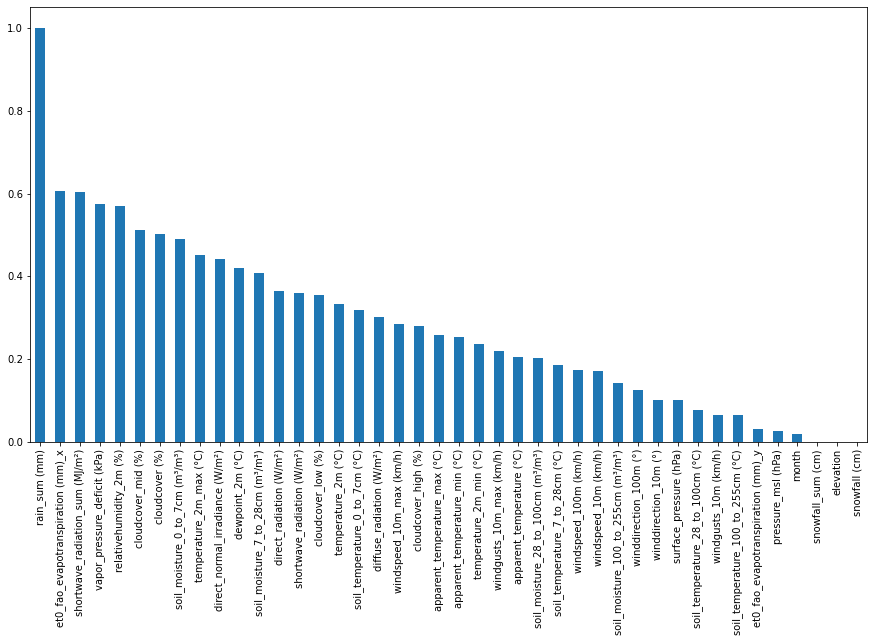

In [150]:
cols = ['pressure_msl (hPa)',
        'surface_pressure (hPa)', 'snowfall (cm)', 'cloudcover (%)',
        'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)',
        'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)',
        'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)',
        'vapor_pressure_deficit (kPa)', 'soil_temperature_0_to_7cm (°C)',
        'soil_temperature_7_to_28cm (°C)', 'soil_temperature_28_to_100cm (°C)',
        'soil_temperature_100_to_255cm (°C)', 'soil_moisture_0_to_7cm (m³/m³)',
        'soil_moisture_7_to_28cm (m³/m³)', 'soil_moisture_28_to_100cm (m³/m³)',
        'soil_moisture_100_to_255cm (m³/m³)']
merge_b=pd.merge(train_b,train_hourly_b[cols], how='inner', left_index=True, right_index=True)
merge_b['month'] = merge_b.index.month
merge_b['month'] = merge_b.index.year
abs(merge_b.corr()['rain_sum (mm)']).sort_values(ascending=False).plot(kind='bar')

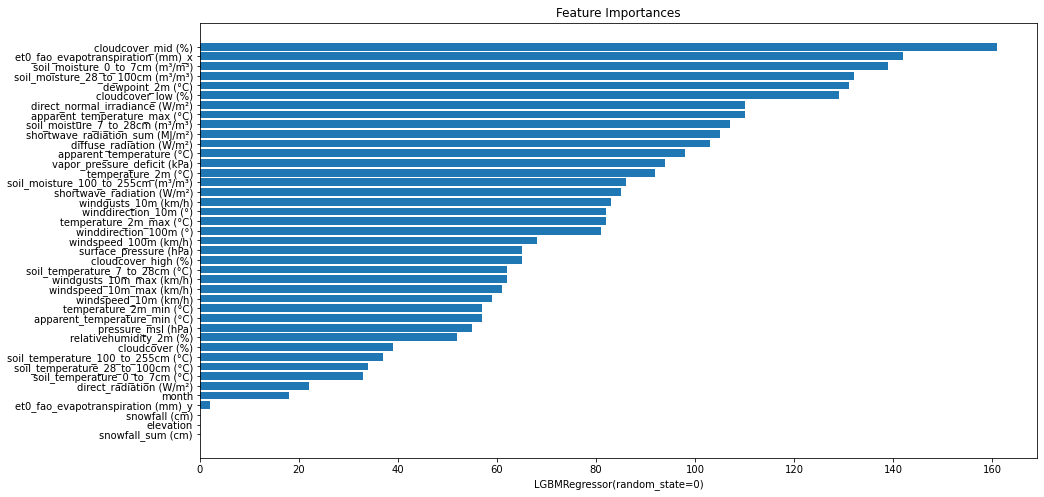

In [159]:

def tree_importance(data,model_):  
  # initialize the model : Tree Based
  model = model_
  feature = [x for x in data.columns if x not in ['rain_sum (mm)','city','sunrise (iso8601)','sunset (iso8601)']]
  model.fit(data[feature],data['rain_sum (mm)'])

  importances = model.feature_importances_
  idxs = np.argsort(importances)

  plt.title('Feature Importances')
  plt.barh(range(len(idxs)), importances[idxs], align='center')
  plt.yticks(range(len(idxs)), [feature[i] for i in idxs]) 
  plt.xlabel(f'{model_}')
  plt.show()

if __name__ == "__main__":
  for i in [lightgbm.LGBMRegressor(random_state=0)] : 
    tree_importance(data,i)

In [163]:
import sklearn

# Define an objective function to be minimized.
def objective(trial):
    
    # Invoke suggest methods of a Trial object to generate hyperparameters.

    lgbm_n_estimators = trial.suggest_int('n_estimators',100,1000,step=10,log=False)
    lgbm_max_depth = trial.suggest_int('max_depth',100,1000,step=10,log=False)
    lgbm_learning_rate = trial.suggest_float('learning_rate', 1e-10, 1, log=True)
    lgbm_boosting_type = trial.suggest_categorical('boosting_type',['gbdt'])
    regressor_obj = lightgbm.LGBMRegressor(learning_rate = lgbm_learning_rate,boosting_type=lgbm_boosting_type)
    
    feature = [x for x in data.columns if x not in ['rain_sum (mm)','city','sunrise (iso8601)','sunset (iso8601)']]

    error = sklearn.model_selection.cross_val_score(regressor_obj,
                                                    merge_b[feature],
                                                    merge_b['rain_sum (mm)'],
                                                    scoring = 'neg_mean_squared_error',
                                                    cv=5)
    accuracy = error.mean()

    return accuracy  # An objective value linked with the Trial object.  # An objective value linked with the Trial object.

if __name__ == "__main__":
  print(merge_b['rain_sum (mm)'].mean())
  print(merge_b.columns)
  study = optuna.create_study(direction='maximize')  # Create a new study.
  study.optimize(objective, n_trials=4000)

[I 2023-01-13 23:23:25,700] A new study created in memory with name: no-name-edcd34f0-ddc5-4640-b526-ed43f08bfac8


7.434578043315903
Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)',
       'sunrise (iso8601)', 'sunset (iso8601)',
       'shortwave_radiation_sum (MJ/m²)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'windspeed_10m_max (km/h)', 'windgusts_10m_max (km/h)',
       'et0_fao_evapotranspiration (mm)_x', 'elevation', 'city',
       'temperature_2m (°C)', 'relativehumidity_2m (%)', 'dewpoint_2m (°C)',
       'apparent_temperature (°C)', 'pressure_msl (hPa)',
       'surface_pressure (hPa)', 'snowfall (cm)', 'cloudcover (%)',
       'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)',
       'shortwave_radiation (W/m²)', 'direct_radiation (W/m²)',
       'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)',
       'windspeed_10m (km/h)', 'windspeed_100m (km/h)',
       'winddirection_10m (°)', 'winddirection_100m (°)',
       'windgusts_10m (km/h)', 'et0_fao_evapotranspiration (mm)_y',

[I 2023-01-13 23:23:26,561] Trial 0 finished with value: -28.732265182718436 and parameters: {'n_estimators': 400, 'max_depth': 830, 'learning_rate': 0.17924454127569167, 'boosting_type': 'gbdt'}. Best is trial 0 with value: -28.732265182718436.
[I 2023-01-13 23:23:27,230] Trial 1 finished with value: -59.96668051911854 and parameters: {'n_estimators': 960, 'max_depth': 670, 'learning_rate': 2.100013765377372e-06, 'boosting_type': 'gbdt'}. Best is trial 0 with value: -28.732265182718436.
[I 2023-01-13 23:23:27,876] Trial 2 finished with value: -59.979871260478696 and parameters: {'n_estimators': 1000, 'max_depth': 180, 'learning_rate': 1.0299525064240913e-10, 'boosting_type': 'gbdt'}. Best is trial 0 with value: -28.732265182718436.
[I 2023-01-13 23:23:28,525] Trial 3 finished with value: -59.97986942390442 and parameters: {'n_estimators': 660, 'max_depth': 420, 'learning_rate': 3.953026754214928e-10, 'boosting_type': 'gbdt'}. Best is trial 0 with value: -28.732265182718436.
[I 2023-01